In [54]:
%reset
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [55]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['n0']:
                label = 1
            elif wbc_type in ['n1']:
                label = 2
            elif wbc_type in ['n2']:
                label = 3  
            elif wbc_type in ['n3']:
                label = 4 
            elif wbc_type in ['n4']:
                label = 5 
            else:
                label = 6
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data('/home/hiten/Desktop/Hackathon/Train/')
#X_test, y_test = get_data('/home/hiten/Desktop/Hackathon/Validation/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical

#y_testHot = to_categorical(y_test, num_classes = 5)
#print(dict_characters)

  0%|          | 0/37 [00:00<?, ?it/s]/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 32/32 [00:06<00:00,  5.30it/s]


In [56]:
y_trainHot = to_categorical(y_train, num_classes = 6)

In [57]:
X_test, y_test= get_data('/home/hiten/Desktop/Hackathon/Validation/')
y_testHot = to_categorical(y_test, num_classes = 6)

  0%|          | 0/37 [00:00<?, ?it/s]/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 32/32 [00:06<00:00,  5.04it/s]


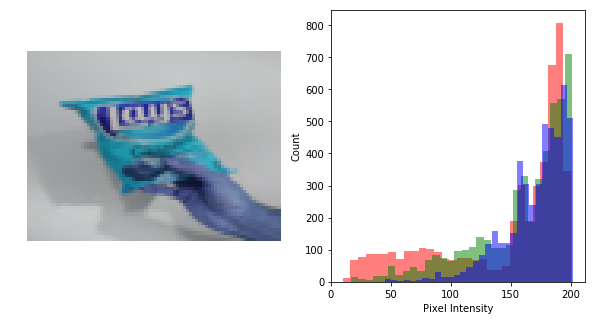

In [58]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

In [59]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0


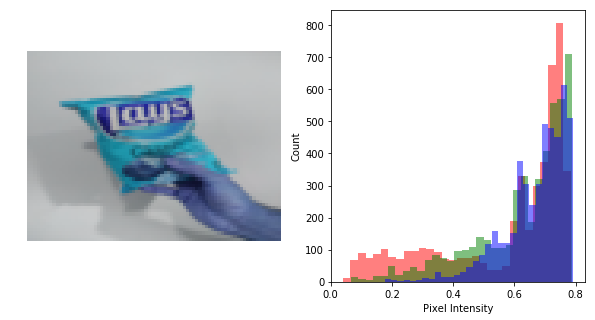

In [60]:
plotHistogram(X_train[1])


In [61]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [62]:
import keras
dict_characters = {1:'coke',2:'doritos',3:'bar',4:'lays', 5:'fruit_snack'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)


Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor of shape [128] and type float
	 [[node dense_1/Const (defined at /home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:430)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [128] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'dense_1/Const', defined at:
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-3f2331b7d35b>", line 51, in <module>
    runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)
  File "<ipython-input-62-3f2331b7d35b>", line 18, in runKerasCNNAugment
    model.add(Dense(128, activation='relu'))
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/sequential.py", line 181, in add
    output_tensor = layer(self.outputs[0])
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/layers/core.py", line 872, in build
    constraint=self.bias_constraint)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/initializers.py", line 38, in __call__
    return K.constant(0, shape=shape, dtype=dtype)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 430, in constant
    return tf.constant(value, dtype=dtype, shape=shape, name=name)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 214, in constant
    name=name).outputs[0]
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [128] and type float
	 [[node dense_1/Const (defined at /home/hiten/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:430)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [128] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
